# Importance of group ID
I saw some posts on why group id is there in training and a [post from #1 placed submission how he co-related the orientation data with group id.](https://www.kaggle.com/c/career-con-2019/discussion/87239#latest-507715). So I though of exploring the feature importance of group id.

I have done the same standard feature engineering as [this](https://www.kaggle.com/hiralmshah/robot-sensor-eda-fe-and-prediction-improvement) kernel. Else the results would have been even more skewed in the favour of group_id.

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix

In [5]:
!ls ../input

X_test.csv  X_train.csv  sample_submission.csv	y_train.csv


https://www.kaggle.com/hiralmshah/robot-sensor-eda-fe-and-prediction-improvement

In [3]:
def feat_eng1(data):
    data['norm_q'] = data['orientation_X'] ** 2 + data['orientation_Y'] ** 2 + data['orientation_Z'] ** 2 + data['orientation_W']**2
    data['mod_q'] = data['norm_q'] ** 0.5
    data['norm_X'] = data['orientation_X'] / data['mod_q']
    data['norm_Y'] = data['orientation_Y'] / data['mod_q']
    data['norm_Z'] = data['orientation_Z'] / data['mod_q']
    data['norm_W'] = data['orientation_W'] / data['mod_q']
    return data

In [7]:
def feat_eng2(data):
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_orientation'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    return data

In [8]:
from astropy.stats import median_absolute_deviation
from statsmodels.robust.scale import mad

def feat_eng3(data):
    df = pd.DataFrame()
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + 'median_abs_dev'] = data.groupby(['series_id'])[col].mad()
    return df

In [10]:
from fastai.imports import *


In [13]:
PATH = "../input/"

In [15]:
train_df = pd.read_csv(f"{PATH}X_train.csv")
test_df = pd.read_csv(f"{PATH}/X_test.csv")
train_df = feat_eng1(train_df)
test_df = feat_eng1(test_df)
train_df = feat_eng2(train_df)
test_df = feat_eng2(test_df)

In [16]:
train_df = feat_eng3(train_df)
test_df = feat_eng3(test_df)

In [20]:
label_df = pd.read_csv(f"{PATH}y_train.csv")

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [22]:
le = LabelEncoder()

In [23]:
le.fit(label_df.surface.unique())

LabelEncoder()

In [24]:
y = le.transform(label_df.surface)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=42)

In [43]:
model = RandomForestClassifier()

In [44]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
accuracy_score(model.predict(X_test), y_test)

0.8268625393494229

In [46]:
def feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [47]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

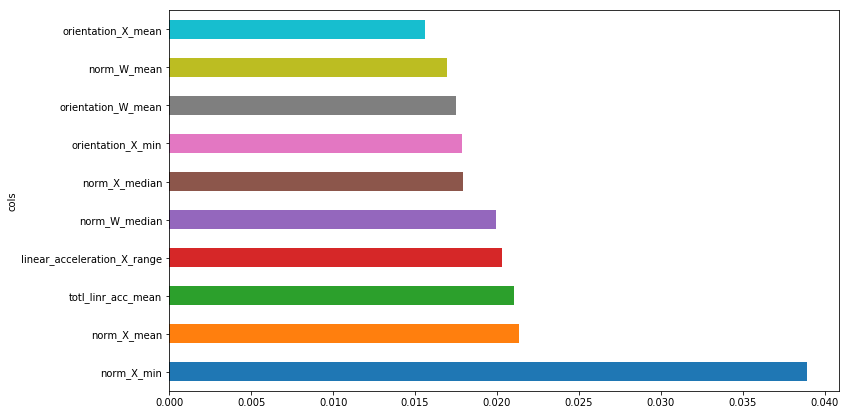

In [48]:
fi = feat_importance(model, train_df)
plot_fi(fi[:10])

In [49]:
joined_df = train_df.join(label_df, on="series_id")

In [50]:
joined_df.drop("surface", axis=1, inplace=True)

In [51]:
group_model = RandomForestClassifier()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(joined_df, y, random_state=42)

In [53]:
group_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
accuracy_score(group_model.predict(X_test), y_test)

0.8908709338929696

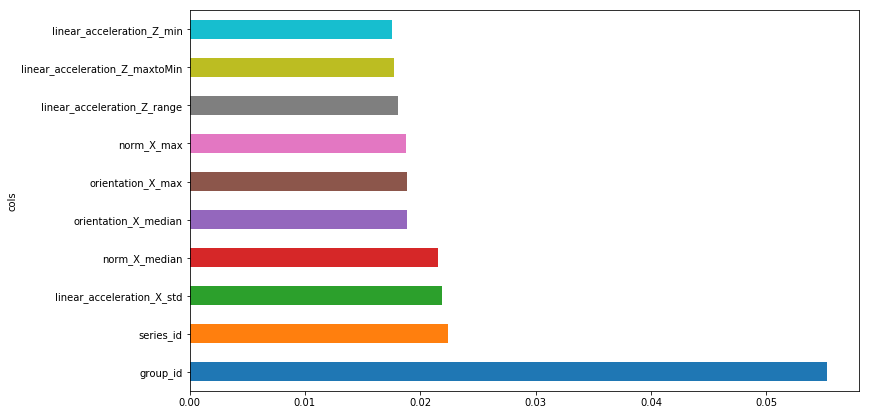

In [58]:
g_fi = feat_importance(group_model, X_train)
plot_fi(g_fi[:10])

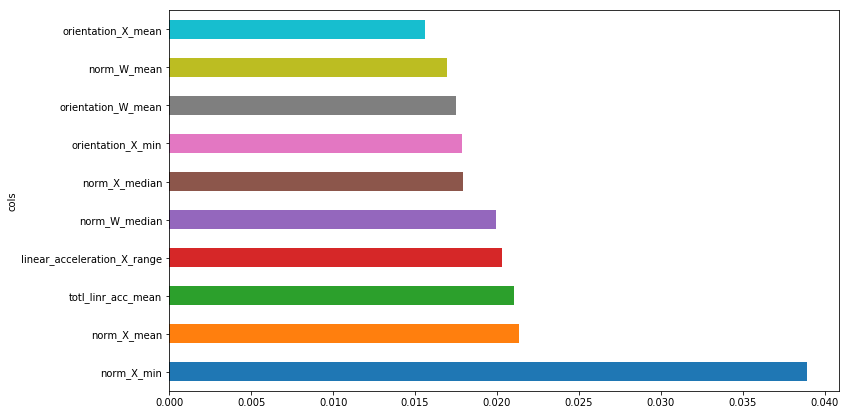

In [57]:
plot_fi(fi[:10])

See how the feature importance shifts by including group_id